# 桑坦德客户满意度 Santander Customer Satisfaction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from scipy.sparse import hstack
import itertools
import random

In [2]:
# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns
# 特征工程
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# 非平衡取
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 模型
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error, f1_score, roc_auc_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
#杂项
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# 1.1 Loading the data

In [3]:
train = pd.read_csv("../data/input/train.csv")
test = pd.read_csv("../data/input/test.csv")
sample = pd.read_csv("../data/input/sample_submission.csv")

## 1.2 Description of data set 数据集描述
您将获得一个包含大量数字变量的匿名数据集。

- “Target”列是要预测的变量。不满意的客户为 1，满意的客户为 0。
- 任务是预测测试集中每个客户是不满意客户的概率。
- 369 个匿名特征

In [4]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [6]:
sample.head()

,ID,TARGET
0,2,0
1,5,0
2,6,0
3,7,0
4,9,0


In [7]:
train.describe().round(3).T.to_csv('output/train_describe.csv')

### 结论大多数特性都是0， 需要过滤无用特征和稀疏化特征

In [8]:
train.shape, test.shape, sample.shape

((76020, 371), (75818, 370), (75818, 2))

In [9]:
print('Null values in training data is {}'.format(train.isnull().sum().any()))
print('Null values in testing data is {}'.format(test.isnull().sum().any()))

Null values in training data is False
Null values in testing data is False


In [10]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Columns: 370 entries, ID to var38
dtypes: float64(110), int64(260)
memory usage: 214.0 MB


(None, None)

## 1.3 Preprocessing the data

### 删除所有只有 1 个唯一值的列(0 方差），因为没什么用

In [11]:
# Removing all the columns having only 1 unique value.
j = 0
for col in train.columns:
    if train[col].nunique() == 1:
        j += 1
        # print(i, print("删除的columns"))
        #train.drop(i, inplace = True, axis = 1)
        #test.drop(i, inplace = True, axis = 1)
        del train[col]
        del test[col]
print('删除的数量: ',j)

删除的数量:  34


In [12]:
# Removing all the columns having only 1 unique value.
j = 0
for col in train.columns:
    if train[col].var() == 0:
        j += 1
        # print(i, print("删除的columns"))
        #train.drop(i, inplace = True, axis = 1)
        #test.drop(i, inplace = True, axis = 1)
        del train[col]
        del test[col]
print('删除的数量: ',j)

删除的数量:  0


### 过滤稀疏特征

In [13]:
i= 0
for col in train.columns:
    if np.percentile(train[col],99) == 0:
        i += 1
        train.drop(col, inplace = True, axis = 1)
        test.drop(col, inplace = True, axis = 1)
print('删除的数量: ',i)

删除的数量:  188


In [14]:
combinations = list(itertools.combinations(train.columns,2))
print(combinations[:20])
print(len(combinations))

remove =[]
keep = []
for f1, f2 in combinations:
    if (f1 not in remove) & (f2 not in remove):
        if train[f1].equals(train[f2]):
            remove.append(f1)
            keep.append(f2)
train.drop(remove, axis = 1, inplace = True)
test.drop(remove, axis = 1, inplace = True)
print("%i 个特征是重复的, 删除%i 个" % (len(remove)*2, len(remove)))
print("其中特征 %s 被删除\t %i 个特征被保留" %(remove, len(keep)))

del remove
del keep
del combinations

[('ID', 'var3'), ('ID', 'var15'), ('ID', 'imp_ent_var16_ult1'), ('ID', 'imp_op_var39_comer_ult1'), ('ID', 'imp_op_var39_comer_ult3'), ('ID', 'imp_op_var41_comer_ult1'), ('ID', 'imp_op_var41_comer_ult3'), ('ID', 'imp_op_var41_efect_ult1'), ('ID', 'imp_op_var41_efect_ult3'), ('ID', 'imp_op_var41_ult1'), ('ID', 'imp_op_var39_efect_ult1'), ('ID', 'imp_op_var39_efect_ult3'), ('ID', 'imp_op_var39_ult1'), ('ID', 'ind_var1_0'), ('ID', 'ind_var5_0'), ('ID', 'ind_var5'), ('ID', 'ind_var8_0'), ('ID', 'ind_var8'), ('ID', 'ind_var12_0'), ('ID', 'ind_var12')]
11026
12 个特征是重复的, 删除6 个
其中特征 ['ind_var26_0', 'ind_var25_0', 'ind_var37_0', 'num_var26_0', 'num_var25_0', 'num_var37_0'] 被删除	 6 个特征被保留


In [15]:
train.shape, test.shape

((76020, 143), (75818, 142))

# 2. EDA 探索性数据分析

## 2.1 粗略看一下

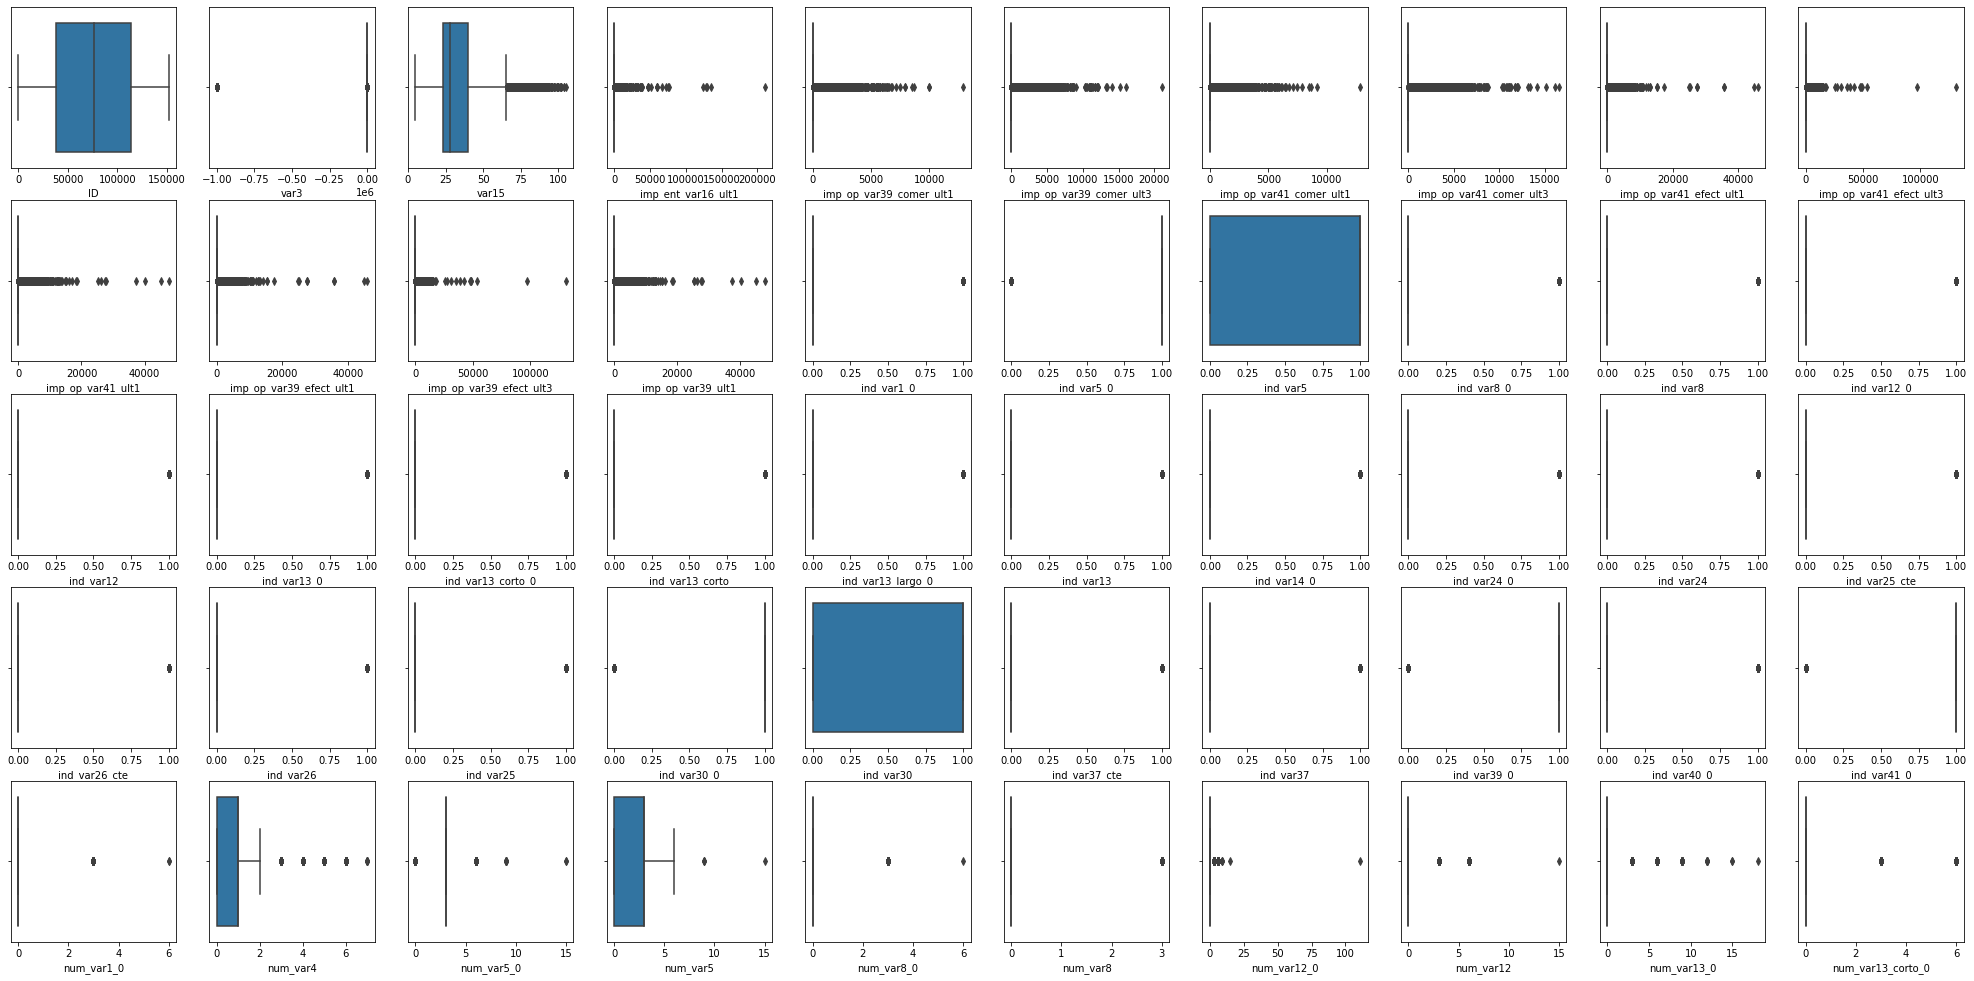

In [16]:
plt.figure(figsize = (35,35))
for i in range (50):
    plt.subplot(10, 10, i+1)
    sns.boxplot(train.iloc[:,i])
    plt.xlabel(train.columns[i], size = 10)

重点var15

### 2.2 绘图函数

In [17]:
def countplot_target(df, h = 500):
    """
    频率分布，满意客户和不满意客户的数量
    h:高度
    """
    plt.figure(figsize = (8,5))
    plt.rcParams["font.sans-serif"] = ['SimHei']
    plt.rcParams["axes.unicode_minus"] = False
    
    ax = sns.countplot(x='TARGET', data = df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height + h,
               '{:1.2f}%'.format(height*100/df.shape[0]), ha = "center")
                
    plt.title("Target变量的频率分布图")
    print("满意客户的数量为%i, 不满意客户的数量为 %i" %
          (df[df['TARGET'] == 0].shape[0], df[df['TARGET'] == 1].shape[0]))
    plt.show()
    

                                                  
    

In [18]:
def histplot_comb(col, train = train, test=test, size = (20,5), bins = 20):
    """
    绘制训练集和测试集某一特征的直方图
    """
    
    plt.subplots(1,2, figsize =size)
    plt.subplot(121)
    plt.title("训练集特征{}的分布".format(col))
    plt.ylabel("频数")
    plt.xlabel(col)
    plt.hist(train[col], bins = bins)
    
    plt.subplot(122)
    plt.title("训练集特征{}的分布".format(col))
    plt.ylabel("频数")
    plt.xlabel(col)
    plt.hist(test[col], bins = bins)
    

In [19]:
def valuecounts_plot(col, train=train, test = test):
    """
    绘制训练集和测试集特定列的频数分布折线图，并输出出现百分比最高的前五个值和最低的前五个值
    """
    plt.subplots(1,2,figsize=(15,6))
    plt.subplot(121)
    df = train[col].value_counts().sort_index()
    sns.lineplot(x=df.index, y =df.values)
    plt.title("%s的频率分布折线图" % (col))
    plt.ylabel("频数")
    
    plt.subplot(122)
    df = test[col].value_counts().sort_index()
    sns.lineplot(x=df.index, y=df.values)
    plt.title("%s的频数分布折线图" % (col))
    plt.ylabel('频数')
    
    plt.tight_layout()
    plt.show()
    
    print("*"*100)
    print("训练集特征 '%s'其值占比top5：" % (col))
    print("值\t 占比%")
    print((train[col].value_counts()*100/train.shape[0]).iloc[:5])
    print("*"*100)
    print("训练集特征 '%s'其值占比bottom5：" % (col))
    print("值\t 占比%")
    print((train[col].value_counts()*100/train.shape[0]).iloc[-5:])
    
    print("*"*100)
    print("测试集特征 '%s'其值占比top5：" % (col))
    print("值\t 占比%")
    print((test[col].value_counts()*100/train.shape[0]).iloc[:5])
    print("*"*100)
    print("测试集特征 '%s'其值占比bottom5：" % (col))
    print("值\t 占比%")
    print((test[col].value_counts()*100/train.shape[0]).iloc[-5:])

In [20]:
def histplot_target(col, df = train, height = 6, bins = 20):
    """
    绘制数据集特征列再不同目标变量下的频数分布图
    """
    sns.FacetGrid(data =df, hue='TARGET', height=height).map(plt.hist, col,bins=bins).add_legend()
    plt.title("特征%s在不同目标变量下的频数分布" %(col))
    plt.ylabel("频数")
    plt.show()

满意客户的数量为73012, 不满意客户的数量为 3008


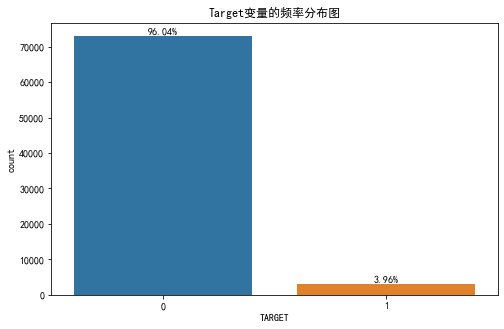

In [21]:
countplot_target(train)

#### var_3 分析， 可能是国家，-9999缺失值

In [22]:
# var_3
np.array(sorted(train.var3.unique()))

array([-999999,       0,       1,       2,       3,       4,       5,
             6,       7,       8,       9,      10,      11,      12,
            13,      14,      15,      16,      17,      18,      19,
            20,      21,      22,      23,      24,      25,      26,
            27,      28,      29,      30,      31,      32,      33,
            34,      35,      36,      38,      40,      41,      42,
            43,      44,      45,      46,      47,      48,      49,
            50,      51,      52,      53,      54,      55,      56,
            57,      58,      59,      60,      61,      62,      63,
            64,      65,      66,      68,      69,      71,      72,
            73,      74,      76,      77,      78,      79,      81,
            82,      84,      85,      86,      87,      88,      89,
            90,      91,      93,      94,      95,      96,      97,
            98,      99,     100,     101,     102,     103,     104,
           105,     

In [23]:
print('值\t 计数\t 训练')
print(train.var3.value_counts()[:5])

print('值\t 占比%\t 训练')
print(train.var3.value_counts()[:5]/train.shape[0]*100)

print('值\t 计数\t 测试')
print(test.var3.value_counts()[:5])

print('值\t 占比%\t 测试')
print(test.var3.value_counts()[:5]/train.shape[0]*100)

值	 计数	 训练
 2         74165
 8           138
-999999      116
 9           110
 3           108
Name: var3, dtype: int64
值	 占比%	 训练
 2         97.559853
 8          0.181531
-999999     0.152591
 9          0.144699
 3          0.142068
Name: var3, dtype: float64
值	 计数	 测试
 2         73962
-999999      120
 8           116
 9           108
 13          107
Name: var3, dtype: int64
值	 占比%	 测试
 2         97.292818
-999999     0.157853
 8          0.152591
 9          0.142068
 13         0.140752
Name: var3, dtype: float64


将-9999 替换为2

In [24]:
train['var3'].replace(-999999,2, inplace= True)
test['var3'].replace(-999999,2, inplace= True)

满意客户的数量为71328, 不满意客户的数量为 2953


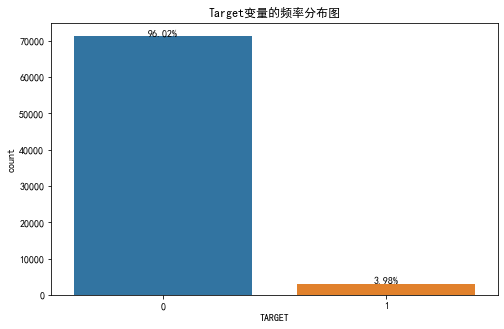

满意客户的数量为1684, 不满意客户的数量为 55


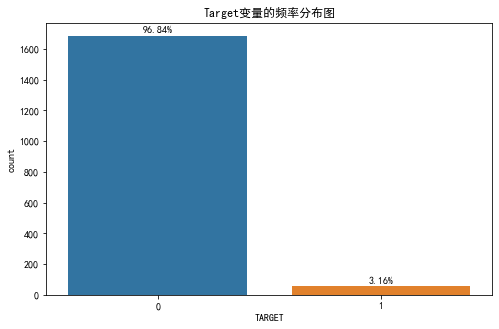

In [25]:
countplot_target(train[train['var3'] == 2], h =20)
countplot_target(train[train['var3'] != 2], h =20)

#### var15(age)

In [26]:
print("最大值为 %i, 最小值为 %i" %(train['var15'].max(), train['var15'].min()))

最大值为 105, 最小值为 5


训练集中年龄在30岁以下的客户占所有数据的 56.15%
训练集中年龄在30岁以下的客户占所有数据的 56.58%


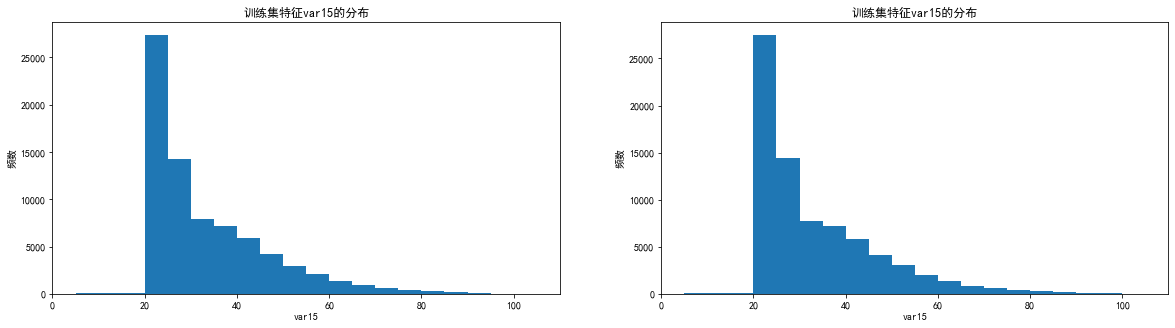

In [27]:
histplot_comb('var15')
print("训练集中年龄在30岁以下的客户占所有数据的 %.2f%%" % (stats.percentileofscore(train['var15'].values, 30)))
print("训练集中年龄在30岁以下的客户占所有数据的 %.2f%%" % (stats.percentileofscore(test['var15'].values, 30)))

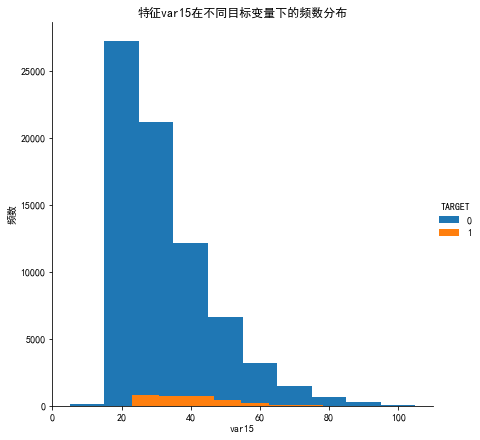

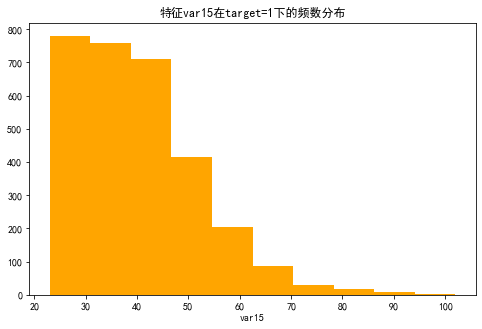

In [28]:
ax= histplot_target('var15', bins=10)

plt.figure(figsize = (8,5))
mask = train[(train['TARGET'] == 1)]

plt.hist(mask['var15'], color='orange')
plt.title('特征var15在target=1下的频数分布')
plt.xlabel('var15')
plt.show()

从上图可以看出，不满意客户的年龄是23-102岁，我们可以创建一个新特征，用来判断客户是否小于23岁

In [29]:
for df in [train, test]:
    df['var15_below23'] = np.zeros(df.shape[0], dtype = int)
    df.loc[df['var15'] <23, 'var15_below23'] = 1

将var15离散化，有助于2分类

In [30]:
_,bins = pd.cut(train['var15'].values, 5, retbins=True)
print(_)

[(4.9, 25.0], (25.0, 45.0], (4.9, 25.0], (25.0, 45.0], (25.0, 45.0], ..., (45.0, 65.0], (25.0, 45.0], (4.9, 25.0], (4.9, 25.0], (45.0, 65.0]]
Length: 76020
Categories (5, interval[float64, right]): [(4.9, 25.0] < (25.0, 45.0] < (45.0, 65.0] < (65.0, 85.0] < (85.0, 105.0]]


In [31]:
train['var15'] = pd.cut(train['var15'].values, bins, labels=False)
test['var15'] = pd.cut(test['var15'].values, bins, labels=False)
train['var15']

0        0
1        1
2        0
3        1
4        1
        ..
76015    2
76016    1
76017    0
76018    0
76019    2
Name: var15, Length: 76020, dtype: int64

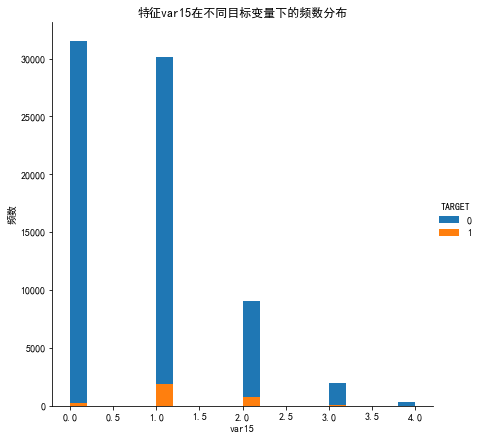

In [32]:
histplot_target('var15')

#### var38(连续性数据)

In [33]:
print("var38 min: %.3f, max :%.3f" % (train['var38'].min(), train['var38'].max()))

var38 min: 5163.750, max :22034738.760


In [34]:
train.var38.value_counts()

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
                 ...  
89665.500000         1
45876.570000         1
151505.640000        1
74548.170000         1
84278.160000         1
Name: var38, Length: 57736, dtype: int64

In [35]:
for i in np.arange(0, 1.1, 0.1):
    print("%i percentile: %i" % (i*100, np.quantile(train.var38.values, i)))

0 percentile: 5163
10 percentile: 48070
20 percentile: 61496
30 percentile: 74152
40 percentile: 88571
50 percentile: 106409
60 percentile: 117310
70 percentile: 117310
80 percentile: 132859
90 percentile: 182585
100 percentile: 22034738


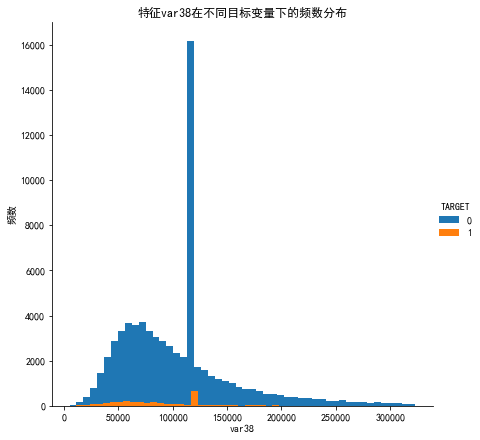

In [36]:
mask = train[train['var38']<= np.quantile(train.var38.values, 0.975)]
histplot_target('var38', df = mask, bins =50)

#### 对var38进行对数变换

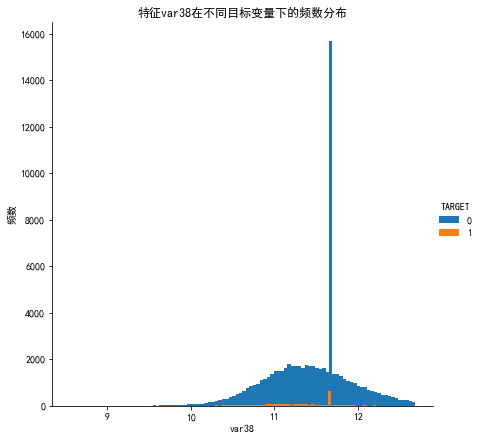

In [37]:
mask['var38'] = np.log(mask.var38).values
histplot_target('var38', df = mask, bins =100)

#### var36 & var 21

In [38]:
train.var36.value_counts()

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

In [39]:
train.var21.value_counts()

0        75152
900        236
1800       206
4500        96
3000        84
7200        62
3600        52
1500        31
6000        27
2700        26
9000        14
1200        12
5400         4
2400         3
18000        2
3300         2
4200         2
5100         2
2100         2
5700         1
10500        1
6600         1
7500         1
30000        1
Name: var21, dtype: int64

### 分析带关键词前缀特征

In [40]:
import re
[col for col in train.columns if col[:3] == 'var']

['var3', 'var15', 'var36', 'var21', 'var38', 'var15_below23']

In [41]:
#f_keywords = {col.split("_")[0] for col in train.columns if (len(col.split("_"))>1 ) and ~("var" in  col)}
f_keywords = {'imp', 'ind', 'num', 'saldo'}
f_keywords

{'imp', 'ind', 'num', 'saldo'}

In [42]:
f_keywords = dict(zip(f_keywords,np.zeros(len(f_keywords), dtype = int)))

for key in f_keywords.keys():
    for col in train.columns:
        if key in col:
            f_keywords[key] += 1
f_keywords

{'ind': 32, 'num': 64, 'saldo': 26, 'imp': 14}

Text(0.5, 0, '关键词前缀')

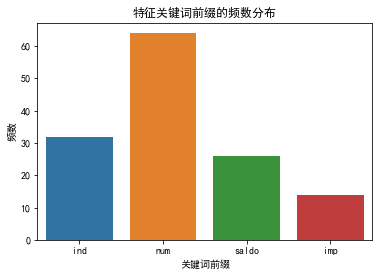

In [43]:
k = pd.Series(f_keywords)
ax = sns.barplot(x = k.index, y =k.values)
plt.title("特征关键词前缀的频数分布")
plt.ylabel("频数")
plt.xlabel("关键词前缀")


#### imp特征

In [44]:
imp = [col for col in train.columns if 'imp' in col]
print(len(imp))
imp

14


['imp_ent_var16_ult1',
 'imp_op_var39_comer_ult1',
 'imp_op_var39_comer_ult3',
 'imp_op_var41_comer_ult1',
 'imp_op_var41_comer_ult3',
 'imp_op_var41_efect_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var41_ult1',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_op_var39_ult1',
 'imp_aport_var13_hace3',
 'imp_var43_emit_ult1',
 'imp_trans_var37_ult1']

In [45]:
import random
random.seed(a=0)
random.sample(imp,1)

['imp_trans_var37_ult1']

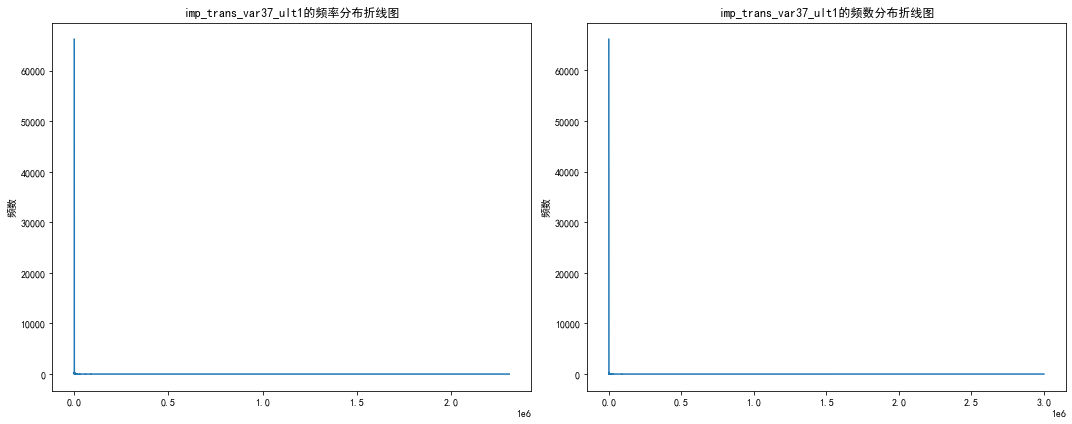

****************************************************************************************************
训练集特征 'imp_trans_var37_ult1'其值占比top5：
值	 占比%
0.0       87.069192
300.0      0.536701
600.0      0.420942
1500.0     0.361747
150.0      0.344646
Name: imp_trans_var37_ult1, dtype: float64
****************************************************************************************************
训练集特征 'imp_trans_var37_ult1'其值占比bottom5：
值	 占比%
2.37       0.001315
4171.68    0.001315
7881.96    0.001315
4740.00    0.001315
792.81     0.001315
Name: imp_trans_var37_ult1, dtype: float64
****************************************************************************************************
测试集特征 'imp_trans_var37_ult1'其值占比top5：
值	 占比%
0.0       87.003420
300.0      0.561694
600.0      0.464351
1500.0     0.390687
3000.0     0.318337
Name: imp_trans_var37_ult1, dtype: float64
****************************************************************************************************
测试集特征 'imp_trans_var37_ult1'其

In [46]:
valuecounts_plot(train=train, test=test, col ='imp_trans_var37_ult1')

In [47]:
col = 'imp_trans_var37_ult1'
df = train[train[col] != 0]
df1 = test[test[col] != 0]
for data in [df,df1]:
    data.loc[data[col] != 0, col] = np.log(data.loc[data[col] != 0, col])

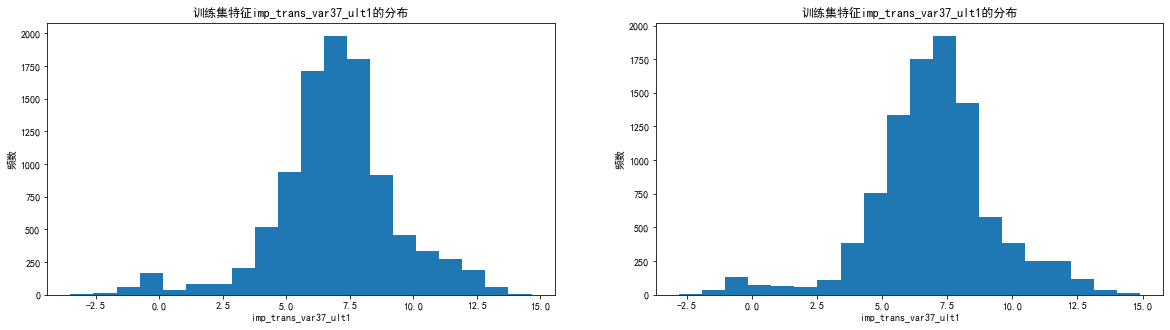

In [48]:
histplot_comb(col, train = df, test =df1)

In [49]:
saldo = [col for col in train.columns if 'saldo' in col]
print(len(saldo))
saldo

26


['saldo_var5',
 'saldo_var8',
 'saldo_var12',
 'saldo_var13_corto',
 'saldo_var13',
 'saldo_var24',
 'saldo_var26',
 'saldo_var25',
 'saldo_var30',
 'saldo_var37',
 'saldo_var42',
 'saldo_medio_var5_hace2',
 'saldo_medio_var5_hace3',
 'saldo_medio_var5_ult1',
 'saldo_medio_var5_ult3',
 'saldo_medio_var8_hace2',
 'saldo_medio_var8_ult1',
 'saldo_medio_var8_ult3',
 'saldo_medio_var12_hace2',
 'saldo_medio_var12_hace3',
 'saldo_medio_var12_ult1',
 'saldo_medio_var12_ult3',
 'saldo_medio_var13_corto_hace2',
 'saldo_medio_var13_corto_hace3',
 'saldo_medio_var13_corto_ult1',
 'saldo_medio_var13_corto_ult3']

#### num_var

In [50]:
num = [col for col in train.columns if 'num' in col]
print(len(num))
num

64


['num_var1_0',
 'num_var4',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var8',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13',
 'num_var14_0',
 'num_var24_0',
 'num_var24',
 'num_var26',
 'num_var25',
 'num_op_var41_hace2',
 'num_op_var41_hace3',
 'num_op_var41_ult1',
 'num_op_var41_ult3',
 'num_op_var39_hace2',
 'num_op_var39_hace3',
 'num_op_var39_ult1',
 'num_op_var39_ult3',
 'num_var30_0',
 'num_var30',
 'num_var35',
 'num_var37_med_ult2',
 'num_var37',
 'num_var39_0',
 'num_var40_0',
 'num_var41_0',
 'num_var42_0',
 'num_var42',
 'num_aport_var13_hace3',
 'num_ent_var16_ult1',
 'num_var22_hace2',
 'num_var22_hace3',
 'num_var22_ult1',
 'num_var22_ult3',
 'num_med_var22_ult3',
 'num_med_var45_ult3',
 'num_meses_var5_ult3',
 'num_meses_var8_ult3',
 'num_meses_var12_ult3',
 'num_meses_var13_corto_ult3',
 'num_meses_var39_vig_ult3',
 'num_op_var39_comer_ult1',
 'num_op_var39_comer_ult3',
 'num_op_var41_co

In [51]:
col = 'num_var5'
print((train[col].min()),(train[col].max()))
print((test[col].min()),(test[col].max()))

0 15
0 12


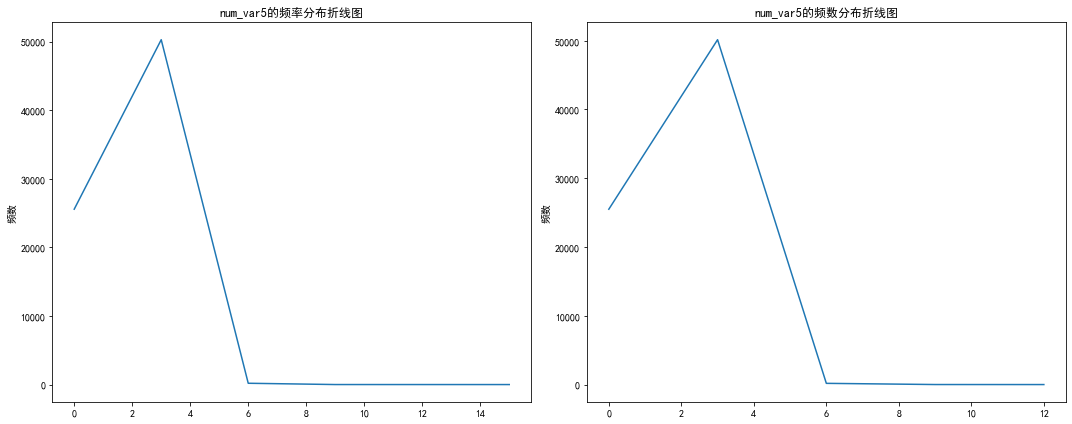

****************************************************************************************************
训练集特征 'num_var5'其值占比top5：
值	 占比%
3     66.120758
0     33.624046
6      0.249934
9      0.003946
15     0.001315
Name: num_var5, dtype: float64
****************************************************************************************************
训练集特征 'num_var5'其值占比bottom5：
值	 占比%
3     66.120758
0     33.624046
6      0.249934
9      0.003946
15     0.001315
Name: num_var5, dtype: float64
****************************************************************************************************
测试集特征 'num_var5'其值占比top5：
值	 占比%
3     65.957643
0     33.535912
6      0.232833
9      0.006577
12     0.001315
Name: num_var5, dtype: float64
****************************************************************************************************
测试集特征 'num_var5'其值占比bottom5：
值	 占比%
3     65.957643
0     33.535912
6      0.232833
9      0.006577
12     0.001315
Name: num_var5, dtype: float64


In [52]:
valuecounts_plot(train=train, test = test, col=col)

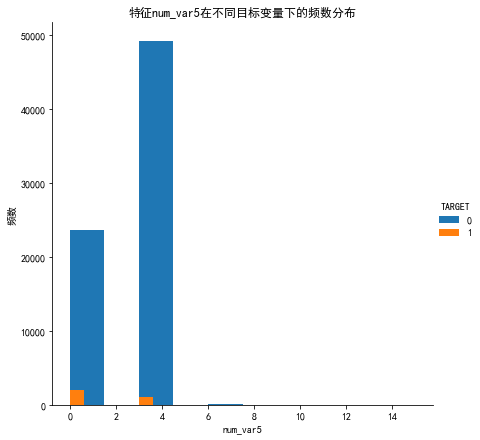

In [53]:
histplot_target(col=col, bins=10)
for i in train[col].unique():
    (col, i, train[(train['TARGET']==1)&(train[col]==i)].shape[0],
     train[(train['TARGET'] == 1) & (train[col]==1)].shape[0]*100 /train[train[col] == i].shape[0])

In [54]:
for feat in num:
    print("%s \t unique values:%i \t dtype:%s" %(feat, train[feat].nunique(), train[feat].dtype))

num_var1_0 	 unique values:3 	 dtype:int64
num_var4 	 unique values:8 	 dtype:int64
num_var5_0 	 unique values:5 	 dtype:int64
num_var5 	 unique values:5 	 dtype:int64
num_var8_0 	 unique values:3 	 dtype:int64
num_var8 	 unique values:2 	 dtype:int64
num_var12_0 	 unique values:6 	 dtype:int64
num_var12 	 unique values:4 	 dtype:int64
num_var13_0 	 unique values:7 	 dtype:int64
num_var13_corto_0 	 unique values:3 	 dtype:int64
num_var13_corto 	 unique values:3 	 dtype:int64
num_var13_largo_0 	 unique values:7 	 dtype:int64
num_var13 	 unique values:7 	 dtype:int64
num_var14_0 	 unique values:5 	 dtype:int64
num_var24_0 	 unique values:4 	 dtype:int64
num_var24 	 unique values:3 	 dtype:int64
num_var26 	 unique values:9 	 dtype:int64
num_var25 	 unique values:9 	 dtype:int64
num_op_var41_hace2 	 unique values:51 	 dtype:int64
num_op_var41_hace3 	 unique values:22 	 dtype:int64
num_op_var41_ult1 	 unique values:68 	 dtype:int64
num_op_var41_ult3 	 unique values:96 	 dtype:int64
num_op_v

num 特征做以下处理：对唯一值的最大数量设置一个阈值，以便可以将特征定义为分类特征

In [55]:
ind = [col for col in train.columns if 'ind' in col]
print(len(ind))
ind

32


['ind_var1_0',
 'ind_var5_0',
 'ind_var5',
 'ind_var8_0',
 'ind_var8',
 'ind_var12_0',
 'ind_var12',
 'ind_var13_0',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13_largo_0',
 'ind_var13',
 'ind_var14_0',
 'ind_var24_0',
 'ind_var24',
 'ind_var25_cte',
 'ind_var26_cte',
 'ind_var26',
 'ind_var25',
 'ind_var30_0',
 'ind_var30',
 'ind_var37_cte',
 'ind_var37',
 'ind_var39_0',
 'ind_var40_0',
 'ind_var41_0',
 'ind_var10_ult1',
 'ind_var10cte_ult1',
 'ind_var9_cte_ult1',
 'ind_var9_ult1',
 'ind_var43_emit_ult1',
 'ind_var43_recib_ult1']

In [56]:
col = 'ind_var5_0'
print((train[col].min()),(train[col].max()))
print((test[col].min()),(test[col].max()))

0 1
0 1


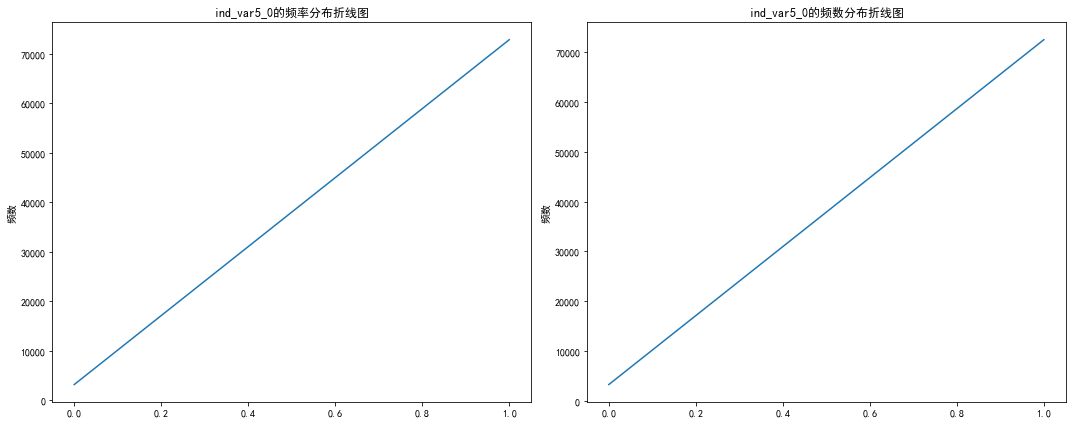

****************************************************************************************************
训练集特征 'ind_var5_0'其值占比top5：
值	 占比%
1    95.80242
0     4.19758
Name: ind_var5_0, dtype: float64
****************************************************************************************************
训练集特征 'ind_var5_0'其值占比bottom5：
值	 占比%
1    95.80242
0     4.19758
Name: ind_var5_0, dtype: float64
****************************************************************************************************
测试集特征 'ind_var5_0'其值占比top5：
值	 占比%
1    95.445935
0     4.288345
Name: ind_var5_0, dtype: float64
****************************************************************************************************
测试集特征 'ind_var5_0'其值占比bottom5：
值	 占比%
1    95.445935
0     4.288345
Name: ind_var5_0, dtype: float64


In [57]:
valuecounts_plot(train=train, test = test, col=col)

In [58]:
train.shape, test.shape

((76020, 144), (75818, 143))

In [59]:
train.to_pickle('output/train.pkl')
test.to_pickle('output/test.pkl')

# 3. 特征工程

In [60]:
train = pd.read_pickle('output/train.pkl')
test = pd.read_pickle('output/test.pkl')
X_train = train.copy()
X_test = test.copy()
X_train.shape,X_test.shape

((76020, 144), (75818, 143))

### 构造新特征 零或非0出现次数

In [61]:
def add_feature_no_zeros(train =X_train, test=X_test):
    """
    构建新特征，表示每行样本中143个特征取值为0或者非0的出现次数
    """
    col = [k for k in train.columns if k!= 'TARGET']
    for df in [train, test]:
        df['no_zeros'] = (df.loc[:, col] == 0).sum(axis=1).values
        df['no_nonzeros'] = (df.loc[:,col]!=0).sum(axis =1).values
        
def add_feature_no_zeros_keyword(keyword, train =X_train, test =X_test):
    """
    构造新特征，表示每行样本对于每一种关键词前缀的特征取值为0或非0的出现次数
    """
    col = [k for k in train.columns if keyword in k]
    for df in [train, test]:  
        df['no_zeros' + k] = (df.loc[:, col] == 0).sum(axis=1).values
        df['no_nonzeros'+ k] = (df.loc[:,col]!=0).sum(axis =1).values
    

In [62]:
add_feature_no_zeros()
keywords = ['imp','saldo', 'num', 'ind']
for k in keywords:
    add_feature_no_zeros_keyword(k)

In [63]:
X_train.shape,X_test.shape

((76020, 154), (75818, 153))

### 构造新特征 - 获取唯一值个数处于（50，210】之间的‘col'特征中取每一种唯一值的情况下，含imp和saldo的前缀特征的均值


In [64]:
def average_col(col, features, train=X_train, test =X_test):
    """
    获取’col'特征中每一种为一值的情况下feature特征的均值，并令其为新特征
    """
    for df in [train, test]:
        unique_values = df[col].unique()
        
        for feature in features:
            avg_value = []
            for value in unique_values:
                avg = df.loc[df[col] == value, feature].mean()
                avg_value.append(avg)
            avg_dict = dict(zip(unique_values, avg_value))
            new_col = 'avg_' + col + "_" + feature
            df[new_col] = np.zeros(df.shape[0])
            for value in unique_values:
                df.loc[df[col] == value, new_col] = avg_dict[value]
            

In [65]:
# 含imp和saldo前缀的所有特征，不包括no_zeros_imp 和 no_zeros_saldo
features = [i for i in X_train.columns if (('imp' in i) | (('saldo' in i)) & ("no_zeros" not in i))]
# 唯一值处于【50，210】之间的特征列
columns = [i for i in X_train.columns if (X_train[i].nunique() <= 210) & (X_train[i].nunique() > 50)]

len(features), len(columns)

(43, 19)

In [66]:
columns

['var3',
 'num_op_var41_hace2',
 'num_op_var41_ult1',
 'num_op_var41_ult3',
 'num_op_var39_ult1',
 'num_op_var39_ult3',
 'num_med_var45_ult3',
 'num_op_var39_comer_ult1',
 'num_op_var39_comer_ult3',
 'num_op_var41_comer_ult1',
 'num_op_var41_comer_ult3',
 'num_var45_hace2',
 'num_var45_hace3',
 'num_var45_ult1',
 'num_var45_ult3',
 'no_zeros',
 'no_nonzeros',
 'no_zerosnum',
 'no_nonzerosnum']

In [67]:
%%time
for col in tqdm(columns):
    average_col(col, features)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:48<00:00,  5.72s/it]

Wall time: 1min 48s


In [68]:
X_train.shape,X_test.shape

((76020, 971), (75818, 970))

## 特征选择
- 删除与目标变量TARGET 低相关的特征和彼此之间高相关的特征

In [69]:
def remove_corr_var(train=X_train, test = X_test, target_threshold= 10**-3, within_threshold = 0.95):
    """
    删除与目标变量相关性低的特征，删除彼此之间相关性高的特征（保留一个）
    """
    # 删除像关性低的特征
    initial_feature = train.shape[1]
    corr = train.drop("ID", axis=1).corr().abs()
    corr_target = pd.DataFrame(corr['TARGET']).sort_values(by='TARGET')
    feat_df = corr_target[(corr_target['TARGET']) <= target_threshold]
    print("有 %i个特征应为与目标变量target的相关系数绝对值小于 %.3f 而被删除" % (feat_df.shape[0], target_threshold))
    print("删除中")
    for df in [train, test]:
        df.drop(feat_df.index, axis=1, inplace=True)
    print("已删除！")
    
    # 删除彼此像关性高的特征
    corr.sort_values(by='TARGET', ascending = False, inplace =True)
    corr  = corr.reindex(columns=corr.index)
    corr.drop('TARGET',axis = 1, inplace = True)
    corr.drop('TARGET',axis = 0, inplace = True)
    corr.drop(feat_df.index,axis = 1, inplace = True)
    corr.drop(feat_df.index, inplace = True)
    upper = corr.where(np.triu(np.ones(corr.shape), k =1).astype(np.bool))
    column = [col for col in upper.columns if any(upper[col] > within_threshold)]
    
    print("有 %i 个特征与另一个特征高度相关且相关系数为 %.3f 及以上而删除" % (len(column), within_threshold))
    print("删除中")
    for df in [train, test]:
        df.drop(column, axis =1, inplace =True)
    print("已删除！")
    print("特征数从%i 个变成 %i 个，其中 %i 个已删除" % 
          (initial_feature, test.shape[1],
                                          initial_feature - test.shape[1])
         )

In [70]:
%%time
remove_corr_var()

有 48个特征应为与目标变量target的相关系数绝对值小于 0.001 而被删除
删除中
已删除！
有 575 个特征与另一个特征高度相关且相关系数为 0.950 及以上而删除
删除中
已删除！
特征数从971 个变成 347 个，其中 624 个已删除
Wall time: 2min 44s


In [71]:
X_train.to_pickle('output/X_train.pkl')
X_test.to_pickle('output/X_test.pkl')

In [72]:
X_train = pd.read_pickle('output/X_train.pkl')
X_test = pd.read_pickle('output/X_test.pkl')
X_train = X_train.copy()
X_test = X_test.copy()

X_train.shape,X_test.shape

((76020, 348), (75818, 347))

## 将imp和saldo进行对数变换

In [73]:
def apply_loglp(column, train=X_train, test =X_test):
    """
    对数变换所有特征
    """
    tr = train.copy()
    te = test.copy()
    for df in [tr,te]:
        for col in column:
            df.loc[df[col] >= 0, col] = np.log1p(df.loc[df[col] >= 0, col].values)
            return tr, te

In [74]:
features = [i for i in X_train.columns if (('saldo' in i)) | ("imp" in i) & ((X_train[i].values >= 0)).all()]#if (('saldo' in i) | ("imp" in i)) & ((X_train[i].values >= 0).all())]
features

['imp_op_var39_comer_ult1',
 'imp_op_var41_comer_ult3',
 'imp_op_var41_ult1',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'saldo_var5',
 'saldo_var8',
 'saldo_var13_corto',
 'saldo_var13',
 'saldo_var26',
 'saldo_var30',
 'saldo_var37',
 'saldo_var42',
 'imp_aport_var13_hace3',
 'imp_var43_emit_ult1',
 'imp_trans_var37_ult1',
 'saldo_medio_var5_hace2',
 'saldo_medio_var5_hace3',
 'saldo_medio_var5_ult1',
 'saldo_medio_var5_ult3',
 'saldo_medio_var8_hace2',
 'saldo_medio_var8_ult1',
 'saldo_medio_var8_ult3',
 'saldo_medio_var12_hace2',
 'saldo_medio_var12_hace3',
 'saldo_medio_var13_corto_hace2',
 'saldo_medio_var13_corto_hace3',
 'no_nonzerosimp',
 'no_zerossaldo',
 'avg_var3_imp_ent_var16_ult1',
 'avg_var3_imp_op_var39_comer_ult1',
 'avg_var3_imp_op_var39_comer_ult3',
 'avg_var3_imp_op_var41_comer_ult1',
 'avg_var3_imp_op_var41_comer_ult3',
 'avg_var3_imp_op_var39_efect_ult1',
 'avg_var3_imp_op_var39_efect_ult3',
 'avg_var3_imp_op_var39_ult1',
 'avg_var3_saldo_var5',
 'av

In [75]:
#features = [i for i in X_train.columns if (('saldo' in i) | ("imp" in i)) & ((X_train[i].values >= 0).all())]
X_train_1, X_test_1 = apply_loglp(features)


In [76]:
X_train_1['num_var25_33']

KeyError: 'num_var25_33'

In [86]:
X_train_1.to_pickle('output/X_train_1.pkl')
X_test_1.to_pickle('output/X_test_1.pkl')

X_train_1.shape,X_test_1.shape

((76020, 348), (75818, 347))

### 独热编码

In [78]:
cat_col = []
for col in X_train.columns:
    if (X_train[col].nunique() <= 10) & (col != 'TARGET') & (X_train[col].nunique() > 2 ):
        cat_col.append(col)
print("有 %i 个特征其唯一值数量（2，10] 并使用它们创建独热编码和响应编码变量，同时删除原始特征" % (len(cat_col)))

有 17 个特征其唯一值数量（2，10] 并使用它们创建独热编码和响应编码变量，同时删除原始特征


In [79]:
def one_hot_encoding(col, train = X_train, test =X_test):
    """
    对训练集和测试集中的特征进行独热编码
    """
    ohe = OneHotEncoder(sparse=True, handle_unknown = 'ignore')
    ohe.fit(train[col])
    feature_names = list(ohe.get_feature_names_out(input_features=col))
    features = list(train.drop(col, axis = 1).columns)
    features.extend(feature_names)
    
    #train
    df = train.copy()
    temp = ohe.transform(df[col])
    df.drop(col, axis =1, inplace= True)
    train = pd.DataFrame(hstack([df.values, temp]).toarray(), columns= features)
    train = train.loc[:, ~train.columns.duplicated(keep = 'first')]
    
     #test
    df = test.copy()
    temp = ohe.transform(df[col])
    df.drop(col, axis =1, inplace= True)
    features.remove('TARGET')
    test = pd.DataFrame(hstack([df.values, temp]).toarray(), columns= features)
    test = train.loc[:, ~test.columns.duplicated(keep = 'first')]
    
    return train, test
    

In [80]:
X_train_ohe, X_test_ohe = one_hot_encoding(cat_col)
X_train_1_ohe, X_test_1_ohe = one_hot_encoding(cat_col, X_train_1, X_test_1)
X_train_ohe.shape, X_test_ohe.shape, X_train_1_ohe.shape, X_test_1_ohe.shape

((76020, 436), (76020, 435), (76020, 436), (76020, 435))

In [85]:
X_test_ohe['TARGET']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
76015    0.0
76016    0.0
76017    0.0
76018    0.0
76019    0.0
Name: TARGET, Length: 76020, dtype: float64

### 响应编码

In [ ]:
def response_encoding_return(df, column, target, alpha = 5000):
    """
    使用带有拉普拉斯平滑的响应编码到分类列column, 并在训练测试验证数据集中转换到相应的列
    此函数用来寻找最优的alpha
    """
    unique_values = set(df[column].values)
    dict_values = {}
    
    for value in unique_values:
        total = len(df[df[column] == value])
        sum_promoted = len(df[(df[column] == value)& df[target] == 1])
        dict_values[value] = np.round((sum_promoted + alpha) / (total + alpha * len(unique_values)), 2)
    return dict_values

In [ ]:
def find_alpha(seed):
    random.seed(seed)
    ran_in = random.randint(0, 10)
    col = [col for col in cat_col if X_train[col].nunique() >3][ran_in]
    
    print('Feature: "%s"' % (col))
    
    for alpha in [100, 500, 1000, 2500, 5000, 10000]:
        print('for alpha %i:%s' % (alpha, response_encoding_return(X_train, col, 'TARGET', alpha = alpha)))

In [ ]:
find_alpha(100)
find_alpha(1000) # 100

In [ ]:
def response_encoding(df, test_df, column, target = 'TARGET', alpha =5000):
    feature = column + "_1"
    feature_ = column + '_0'
    unique_values = set(df[column].values)
    dict_values = {}
    dict_values_ = {}
    for value in unique_values:
        total = len(df[df[column] == value])
        sum_promoted = len(df[(df[column] == value)& df[target] == 1])
        sum_unpromoted = total - sum_promoted
        dict_values[value] = np.round((sum_promoted + alpha) / (total + alpha * len(unique_values)), 2) # 拉普拉斯平滑
        dict_values_[value] = np.round((sum_unpromoted + alpha) / (total + alpha * len(unique_values)), 2)
    dict_values['unknow'] = 0.5
    dict_values_['unknow'] = 0.5
    df[feature] = (df[column].map(dict_values)).values
    df[feature_] = (df[column].map(dict_values)).values
    df.drop(column, axis =1, inplace =True)
                                       
    unique_values_test = set(test_df[column].values)
                                       
    test_df[column] = test_df[column].apply(lambda x: 'unknow' if x in (unique_values_test- unique_values) else x)
    test_df[feature] = (test_df[column].map(dict_values)).values
    test_df[feature_] = (test_df[column].map(dict_values_)).values
    test_df.drop(column, axis =1, inplace = True)
                                       
                                       

In [ ]:
alpha =100
X_train_re = X_train.copy()
X_test_re = X_test.copy()
X_train_1_re = X_train.copy()
X_test_1_re = X_test.copy()
for col in tqdm(cat_col):
    response_encoding(X_train_re,X_test_re, col, alpha=alpha)
    response_encoding(X_train_1_re, X_test_1_re, col, alpha=alpha)
X_train_re.shape, X_test_re.shape, X_train_1_re.shape, X_test_1_re.shape

In [ ]:
X_train_1_ohe['num_var25_33']

### 标准化处理

In [ ]:
def stdzation(train, test):
    #col = [i for i in train.columns if (i != 'TARGET') & (i != 'ID') & (i !='num_var25_33')] ### 有问题
    col = [i for i in train.columns if (i != 'TARGET') & (i != 'ID') ]
    scaler = StandardScaler()
    train[col] = scaler.fit_transform(train[col])
    test[col] = scaler.fit_transform(test[col])

In [ ]:
datasets = [(X_train, X_test), (X_train_re, X_test_re), (X_train_ohe, X_test_ohe),
            (X_train_1, X_test_1), (X_train_1_re, X_test_1_re), (X_train_1_ohe, X_test_1_ohe)]

In [ ]:
for train, test in datasets:
    stdzation(train, test)

In [ ]:
datasets_labels = ['normal', "normal_re", 'normal_ohe', "log", "log_re", "log_ohe"]
print("不同数据集的最终特征数： ")

for i, (train, test) in enumerate(datasets):
    print("%s:\t%i" % (datasets_labels[i], test.shape[1]))

In [ ]:
for  i, (train, test)in enumerate(datasets):
    file = datasets_labels[i] + '.kpl'
    train.to_pickle('output/train_' +file)
    test.to_pickle('output/test_' +file)

# 4. 模型

In [88]:
dataset = 'Normal'
train = pd.read_pickle("output/train_normal.kpl")
test = pd.read_pickle("output/test_normal.kpl")
X_train = train.drop(['ID', 'TARGET'], axis = 1)
y_train = train['TARGET'].values
X_test = test.drop("ID",axis=1)
test_id = test['ID']
del train, test

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train,test_size = 0.15, random_state = 42)
# sttatify = y 
X_train.shape, X_val.shape, X_test.shape

((64617, 346), (11403, 346), (75818, 346))

### 4.1 定义AUC函数和调参函数

In [89]:
global i
i = 0
"""
给出 y_true y_pred时汇出ROC曲线
dataset:哪一个数据集
label:哪一个模型
"""
def plot_auc(y_true, y_pred, label, dataset = dataset):
    if (type(label) != list) & (type(label) != np.array):
        print("\t\t %s on %s dataset \t\t \n" % (label, dataset))
        auc = roc_auc_score(y_true, y_pred)
        logloss = log_loss(y_true, y_pred)
        label_1 = label + "AUC =%.3f" % (auc)

        # 绘图
        fpr, tpr, threshold = roc_curve(y_true, y_pred)
        sns.lineplot(fpr, tpr, label = label_1)
        x= np.arange(0, 1.1, 0.1)
        sns.lineplot(x,x, label = "AUC=0.5")
        plt.title("ROC on %s dataset" % (dataset))
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        print("在 %s 数据集上 %s 模型的logloss = %.3f AUC = %.3f" % (dataset, label, logloss, auc))

        # 
        result_dict ={
            'Model': label,
            'Dataset':dataset,
            'log_loss':logloss,
            'AUC': auc
        }
        return pd.DataFrame(result_dict, index=[i])
    else:
            plt.figure(figsize=(12, 8))
            for k, y in enumerate(12,8):
                fpr, tpr, threshold = roc_curve(y_true, y)
                auc = roc_auc_score(y_true, y)
                label_ = label[k] + 'AUC=%f' % (auc)
                sns.lineplot(fpr, tpr, label = label_)
            
            x = np.arange(0,1.1, 0.1)
            sns.lineplot(x,x, label='AUC=0.5')
            plt.title("Combined ROC")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Postitive Rate")
            plt.legend(bbox_to_anchor = (1.05, 1), loc=2, borderaxespad=0.)
            plt.show()






In [90]:
def find_best_params(model, params, cv =10, n_jobs = -1, X_train = X_train):
    """
    使用随即搜索RandomizedSearchCV调参，返回最佳模型
    """
    random_cv = RandomizedSearchCV(model,
                                  param_distributions = params,
                                  scoring = 'roc_auc',
                                  n_jobs=n_jobs,
                                  cv =cv,
                                  verbose=2)
    random_cv.fit(X_train, y_train)
    print("最佳的AUC得分为： %.3f" % (random_cv.best_score_))
    print("最佳的参数为:%s " % (random_cv.best_params_))
    return random_cv.best_score_, random_cv.best_params_

#### 逻辑回归

In [91]:
model_lr = LogisticRegression(class_weight = "balanced")
params = {
    'penalty': ['l2', "l1"],
    'C': [10.** i for i in np.arange(-3,3,1)],
    'fit_intercept': [True, False],
}

In [92]:
%%time
find_best_params(model_lr, params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
最佳的AUC得分为： 0.790
最佳的参数为:{'penalty': 'l2', 'fit_intercept': False, 'C': 0.1} 
Wall time: 1min 19s


(0.7902228277761716, {'penalty': 'l2', 'fit_intercept': False, 'C': 0.1})

In [93]:
model_lr = LogisticRegression(C=0.01, class_weight='balanced')
model_lr.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced')

		 Logistic Regression on Normal dataset 		 



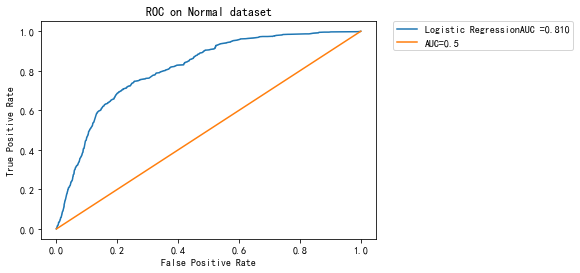

在 Normal 数据集上 Logistic Regression 模型的logloss = 0.539 AUC = 0.810


In [94]:
labels = []
y_preds=[]
y_pred = model_lr.predict_proba(X_val)[:, 1]
label = 'Logistic Regression'
labels.append(label)
y_preds.append(y_pred)

i = 0
result = plot_auc(y_val, y_pred, label, dataset)
result_df = result

del result

#### 决策树

In [95]:
model_dt =  DecisionTreeClassifier(class_weight='balanced')
params = {
    'max_depth':[10, 100, 500, 1000, -1],
    'min_samples_split':[2, 5, 10,100, 500],
    'min_samples_leaf':[1,3,5,7,9],
    'max_leaf_nodes': [100, 500, 1000, 5000, -1]
}


In [96]:
%%time
find_best_params(model_dt, params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
最佳的AUC得分为： 0.790
最佳的参数为:{'min_samples_split': 500, 'min_samples_leaf': 7, 'max_leaf_nodes': 100, 'max_depth': 1000} 
Wall time: 44.8 s


(0.7895022902409433,
 {'min_samples_split': 500,
  'min_samples_leaf': 7,
  'max_leaf_nodes': 100,
  'max_depth': 1000})

In [97]:
model_dt = DecisionTreeClassifier(class_weight='balanced', min_samples_split =  500, min_samples_leaf = 9,max_leaf_nodes=  100,
                                  max_depth =  10)
model_dt.fit(X_train, y_train)
cc_model_dt = CalibratedClassifierCV(model_dt, cv = 'prefit') #校准分类器
cc_model_dt.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_leaf_nodes=100,
                                                        min_samples_leaf=9,
                                                        min_samples_split=500))

		 Decision Tree on Normal dataset 		 



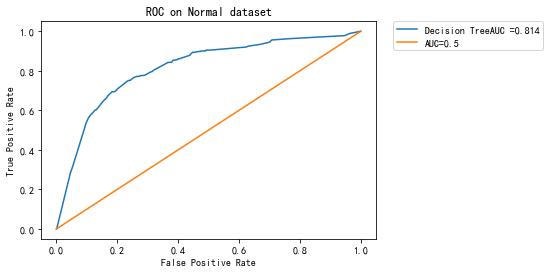

在 Normal 数据集上 Decision Tree 模型的logloss = 0.140 AUC = 0.814


In [98]:
y_pred = cc_model_dt.predict_proba(X_val)[:, 1]
label = "Decision Tree"
labels.append(label)
y_preds.append(y_pred)
i = 0
result = plot_auc(y_val, y_pred, label, dataset)
result_df = result

del result

In [99]:
result_df

,Model,Dataset,log_loss,AUC
0,Decision Tree,Normal,0.139605,0.81436


### 随机森林


In [100]:
model_rf = RandomForestClassifier(class_weight = "balanced")
params = {
    'n_estimators': [1000],
    "max_depth": [1000],
    'min_samples_split':[100],
    "min_samples_leaf":[3],
    'max_leaf_nodes':[100]

}

In [101]:
%time
find_best_params(model_rf, params, cv =2)

Wall time: 0 ns
Fitting 2 folds for each of 1 candidates, totalling 2 fits
最佳的AUC得分为： 0.800
最佳的参数为:{'n_estimators': 1000, 'min_samples_split': 100, 'min_samples_leaf': 3, 'max_leaf_nodes': 100, 'max_depth': 1000} 


(0.7996277559554004,
 {'n_estimators': 1000,
  'min_samples_split': 100,
  'min_samples_leaf': 3,
  'max_leaf_nodes': 100,
  'max_depth': 1000})

In [102]:
model_rf = RandomForestClassifier(class_weight = "balanced")
model_rf.fit(X_train, y_train)
cc_model_rf = CalibratedClassifierCV(model_dt, cv = 'prefit') #校准分类器
cc_model_rf.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_leaf_nodes=100,
                                                        min_samples_leaf=9,
                                                        min_samples_split=500))

		 RF on Normal dataset 		 



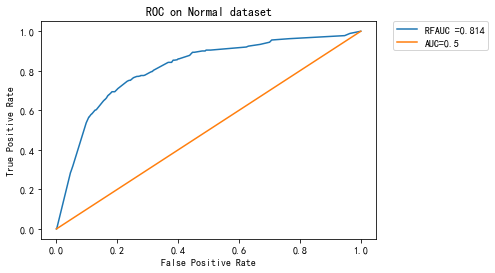

在 Normal 数据集上 RF 模型的logloss = 0.140 AUC = 0.814


In [103]:
y_pred = cc_model_rf.predict_proba(X_val)[:, 1]
label = "RF"
labels.append(label)
y_preds.append(y_pred)
i = 0
result = plot_auc(y_val, y_pred, label, dataset)
result_df = result

del result

In [104]:
result_df

,Model,Dataset,log_loss,AUC
0,RF,Normal,0.139605,0.81436


### XGBoost

In [105]:
model_xgb = XGBClassifier(n_jobs = -1,
                             nthread =1,
                             scale_pos_weight=1.,
                             learning_rate = 0.01,
                             colsample_bytree = 0.5,
                             subsample=0.9,
                             objective="binary:logistic",
                             n_estimators =1000, 
                             reg_alpha=0.3,
                             max_depth=5,
                             gamma=5,
                             random_state=42)

In [106]:
%%time
eval_metric = ['error', 'auc']
eval_set = [(X_train, y_train), (X_val, y_val)]
model_xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric = eval_metric, early_stopping_rounds = 50, verbose =20)

[0]	validation_0-error:0.03942	validation_0-auc:0.73894	validation_1-error:0.03938	validation_1-auc:0.75260
[20]	validation_0-error:0.03957	validation_0-auc:0.81151	validation_1-error:0.03955	validation_1-auc:0.81672
[40]	validation_0-error:0.03957	validation_0-auc:0.81697	validation_1-error:0.03955	validation_1-auc:0.82055
[60]	validation_0-error:0.03957	validation_0-auc:0.81947	validation_1-error:0.03955	validation_1-auc:0.82237
[80]	validation_0-error:0.03957	validation_0-auc:0.82173	validation_1-error:0.03955	validation_1-auc:0.82388
[100]	validation_0-error:0.03957	validation_0-auc:0.82335	validation_1-error:0.03955	validation_1-auc:0.82447
[120]	validation_0-error:0.03957	validation_0-auc:0.82451	validation_1-error:0.03955	validation_1-auc:0.82570
[140]	validation_0-error:0.03957	validation_0-auc:0.82577	validation_1-error:0.03955	validation_1-auc:0.82620
[160]	validation_0-error:0.03956	validation_0-auc:0.82772	validation_1-error:0.03955	validation_1-auc:0.82744
[180]	validation

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              nthread=1, num_parallel_tree=1, predictor='auto', ...)

In [107]:
model_xgb.best_score, model_xgb.best_iteration

(0.8451242187234277, 971)

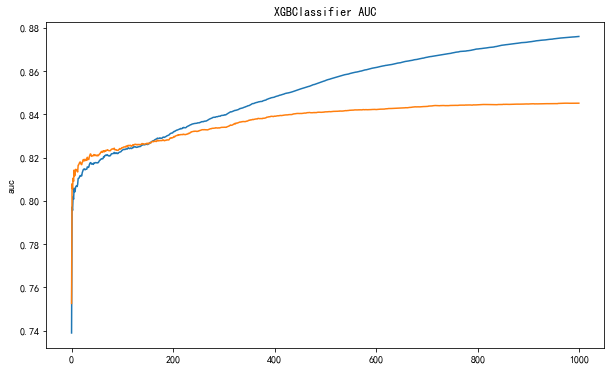

验证集上最大AUC：0.845
最优迭代次数epochs： 971


In [108]:
results = model_xgb.evals_result_
auc_train = results['validation_0']['auc']
auc_val = results['validation_1']['auc']
fig, ax = plt.subplots(figsize=(10,6))
epochs = len(auc_val)

ax.plot(range(0, epochs), auc_train, label='Train')
ax.plot(range(0, epochs), auc_val, label='Test')
ax.legend


plt.title(model_xgb.__class__.__name__+ " " + "AUC")
plt.ylabel("auc")
plt.show()

print("验证集上最大AUC：%.3f"% (max(auc_val)))
print("最优迭代次数epochs： %i" %(auc_val.index(max(auc_val))))

		 XGB on Normal dataset 		 



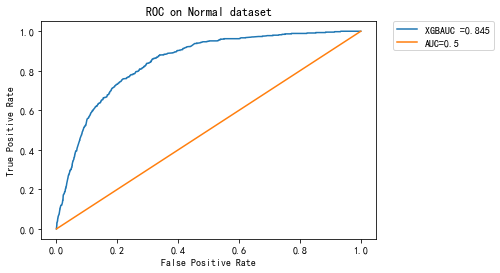

在 Normal 数据集上 XGB 模型的logloss = 0.134 AUC = 0.845


In [109]:
y_pred = model_xgb.predict_proba(X_val)[:, 1]
label = "XGB"
labels.append(label)
y_preds.append(y_pred)
i = 0
result = plot_auc(y_val, y_pred, label, dataset)
result_df = result

del result

In [114]:
result_df

,Model,Dataset,log_loss,AUC
0,XGB,Normal,0.133602,0.845124


In [116]:
y_preds

[array([0.28042226, 0.41516065, 0.06036181, ..., 0.14971322, 0.41794185,
        0.16709898]),
 array([0.08980458, 0.0064008 , 0.0035744 , ..., 0.00413916, 0.00847923,
        0.00413916]),
 array([0.08980458, 0.0064008 , 0.0035744 , ..., 0.00413916, 0.00847923,
        0.00413916]),
 array([0.02914772, 0.0156875 , 0.00509581, ..., 0.00947753, 0.01213228,
        0.01725177], dtype=float32)]

In [111]:
plot_auc(y_val, y_preds.label)

AttributeError: 'list' object has no attribute 'label'

In [ ]:
result_df.sort_values(by='AUC', ascending = False)

### 保存和提交结果

In [112]:
best_model = model_xgb
feat_imp = best_model.feature_importances_
feat_indices = np.argsort(feat_imp)[::-1]
important_feat = X_train.columns[feat_indices]
important_feat

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [113]:
top = 50
top_indices = feat_indices[:top]
most_important_feat = X_train.columns[top_indices]
plt.figure(figsize=(7,12))
sns.barplot(x= feat_imp[top_indices], y = most_important_feat)

plt.title("Feature Importances")
plt.xlabel("Importances")
plt.ylabel("Feature names")
plt.show()

NameError: name 'feat_indices' is not defined

In [ ]:
best_y_pred = best_model.predict_proba(X_test)[:,1]
best_y_pred_df = pd.DataFrame(data = {"ID": test_id, 'TARGET': best_y_pred})
best_y_pred_df.to_csv(dataset + '_submission.csv', index = False)